# LightGBM for the Open University Learning Analytics Dataset (OULAD)

This is done for Research Question 1. The target is to find what are the most important features when predicting student achievement. The features are built using information from the entire duration of the course.

Here, we are using the LightGBM algorithm and the goal is to have the highest possible accuracy. For this, we use methods such as hyperparameter tuning and analyse if recursive feature elimination helps us to achieve our goal. Nonetheless, we use 4 methods to find the most important features.

In [1]:
import pandas as pd # import the used libraries
import matplotlib.pyplot as plt
import shap # use pip install shap command to install the library
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.feature_selection import RFE

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Read the data created by Q1_Final_dataset_dev.ipynb.

In [2]:
data_encoded = pd.read_csv('../Q1TransitionFolder/Q1_data_encoded.csv')
print(data_encoded.shape)
data_encoded.head(5)

(20285, 17)


,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,consistency,TMA_average,CMA_average,TMA_score,CMA_score,Total_average_score,Total_assessment_score,submission_date_average
0,1,3,9.0,2.0,0,240,0,1,934.0,13.701990,82.0,0.0,8240.0,0.0,82.0,8240.0,-1.8
1,0,3,2.0,1.0,0,60,0,1,1435.0,14.307774,66.4,0.0,6540.0,0.0,66.4,6540.0,0.0
2,0,2,5.0,1.0,0,60,0,1,2158.0,13.366931,76.0,0.0,7630.0,0.0,76.0,7630.0,-2.0
3,0,1,5.0,0.0,0,60,0,1,1034.0,10.812709,54.4,0.0,5500.0,0.0,54.4,5500.0,11.4
4,1,2,8.0,1.0,0,60,0,1,2445.0,21.084048,68.0,0.0,6690.0,0.0,68.0,6690.0,2.0


In [3]:
# Separate the target variable, which is 'final_result' from the rest of the independent variables.
X = data_encoded.drop(columns=['final_result'])
y = data_encoded['final_result']

# we choose a random state to have deterministic results
RANDOM_STATE = 42

columns = X.columns.tolist()

# Split the data into training and test sets, where 80% is used for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

This is the hyperparameter tuning part for LightGBM.

In [7]:
# Initialize classifier with no hyperparameters
clf = LGBMClassifier(random_state=RANDOM_STATE)

# Define the parameter grid for grid search.
param_grid = {
    'num_leaves': [31, 127],
    'max_depth': [5, 7, 9, -1],
    'min_data_in_leaf': [30, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000]
}

# We define cross-validation, using stratified k-fold, to ensure proportions.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Initialise the grid search, targeting to increase the accuracy metric.
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,scoring='accuracy', cv=cv, n_jobs=-1, verbose=2)

# Testing the combinations of hyperparameters
grid_search.fit(X, y)

# Print the best parameters determined by the grid search
print(grid_search.best_params_)

# Current best set:
# {'learning_rate': 0.05, 'max_depth': 7, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
{'learning_rate': 0.05, 'max_depth': 7, 'min_data_in_leaf': 30, 'n_estimators': 100, 'num_leaves': 31}


In [4]:
# Initialize our classifier using the hyperparameters obtained earlier
clf = LGBMClassifier(learning_rate = 0.05, max_depth = 7, min_data_in_leaf = 30, n_estimators = 100, num_leaves = 31, random_state=RANDOM_STATE, verbose=-1)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"ROC AUC: {roc_auc}")

# Print detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.8898200640867636
F1 Score: 0.9270204081632654
ROC AUC: 0.9381254712895695
              precision    recall  f1-score   support

           0       0.89      0.68      0.78      1127
           1       0.89      0.97      0.93      2930

    accuracy                           0.89      4057
   macro avg       0.89      0.83      0.85      4057
weighted avg       0.89      0.89      0.88      4057



# Feature importance analysis

In this section, we will analyse the importance of the features. For this, we will use recursive feature elimination, the coefficients of the model, the permutation importance method and SHapley Additive exPlanations (SHAP)

In [11]:
best_accuracy = 0
best_num_features = 0
best_feature_set = None  # To store the best set of features
all_accuracies = []  # List to store all accuracies

for i in range(1, 17):
    # Initialize the Recursive Feature Elimination
    rfe = RFE(estimator=LGBMClassifier(learning_rate=0.01, max_depth=7, min_data_in_leaf=40, n_estimators=500, num_leaves=127, random_state=RANDOM_STATE, verbose=-1), n_features_to_select=i)

    # Fit RFE on the training data
    rfe.fit(X_train, y_train)

    # Predict labels for the test set
    y_pred_rfe = rfe.predict(X_test)

    # Calculate the accuracy for the predictions
    accuracy = accuracy_score(y_test, y_pred_rfe)
    all_accuracies.append(accuracy)

    # If the current accuracy is better than our best, update our best metrics
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_features = i
        best_feature_set = [col for col, selected in zip(X_train.columns, rfe.support_) if selected]

# Results
print(f"Best number of features: {best_num_features} with Accuracy: {best_accuracy:.4f}")
print(f"Best feature set: {best_feature_set}")


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min

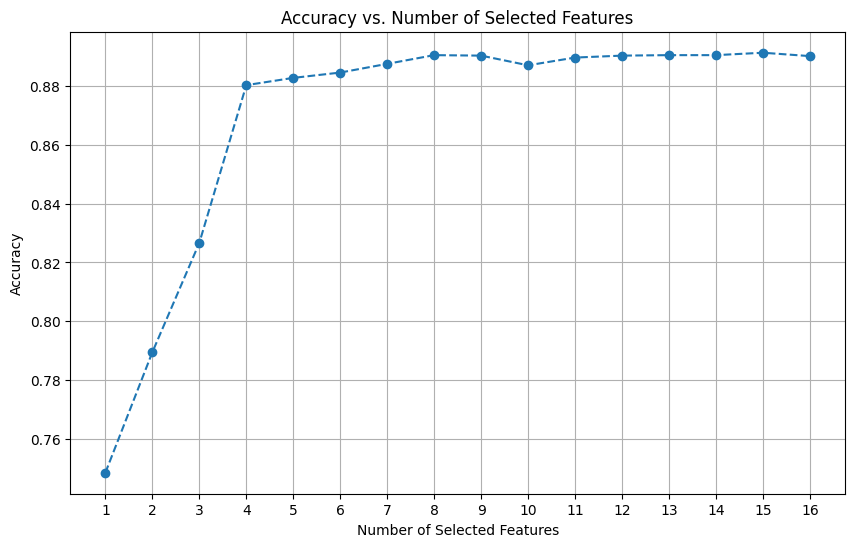

In [12]:
# Visualization of the accuracy values for RFE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 17), all_accuracies, marker='o', linestyle='--')
plt.title('Accuracy vs. Number of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 17, 1))
plt.grid(True)
plt.show()

In [6]:
# Get feature importance
importances = clf.feature_importances_

# Get top 16 features
indices = np.argsort(importances)[::-1][:16]
for i in indices:
    print(f"Feature: {columns[i]}, Importance: {importances[i]}")

Feature: Total_assessment_score, Importance: 450
Feature: sum_click, Importance: 430
Feature: submission_date_average, Importance: 319
Feature: CMA_average, Importance: 278
Feature: Total_average_score, Importance: 276
Feature: consistency, Importance: 274
Feature: TMA_average, Importance: 256
Feature: TMA_score, Importance: 228
Feature: CMA_score, Importance: 194
Feature: imd_band, Importance: 84
Feature: highest_education, Importance: 74
Feature: studied_credits, Importance: 54
Feature: gender, Importance: 44
Feature: disability, Importance: 15
Feature: age_band, Importance: 14
Feature: num_of_prev_attempts, Importance: 10


In [10]:
def permutation_importance(model, X_val, y_val, metric=accuracy_score, random_seed=RANDOM_STATE):
    base_score = metric(y_val, model.predict(X_val))
    feature_importances = []

    np.random.seed(random_seed)  # Setting the random seed for reproducibility

    # Compute feature importances
    for column in X_val.columns:
        X_val_copy = X_val.copy()
        X_val_copy[column] = np.random.permutation(X_val_copy[column].values)

        score = metric(y_val, model.predict(X_val_copy))
        feature_importances.append(base_score - score)

    return np.array(feature_importances)

# Get the feature names corresponding to the top importances
importances = permutation_importance(clf, X_test, y_test)

indices = np.argsort(importances)[::-1][:16]

# Zip the values with the names of the columns
for i in indices:
    print(f"Feature: {X_test.columns[i]}, Importance: {importances[i]}")


Feature: Total_assessment_score, Importance: 0.23662805028346068
Feature: TMA_score, Importance: 0.055952674389943335
Feature: CMA_average, Importance: 0.027853093418782393
Feature: sum_click, Importance: 0.014542765590337736
Feature: CMA_score, Importance: 0.014049790485580527
Feature: consistency, Importance: 0.007394626571358143
Feature: submission_date_average, Importance: 0.003943800838057676
Feature: TMA_average, Importance: 0.0017254128666502888
Feature: highest_education, Importance: 0.000985950209514419
Feature: gender, Importance: 0.0007394626571357588
Feature: age_band, Importance: 0.00024648755237854925
Feature: disability, Importance: 0.0
Feature: num_of_prev_attempts, Importance: 0.0
Feature: studied_credits, Importance: -0.00024648755237866027
Feature: imd_band, Importance: -0.00024648755237866027
Feature: Total_average_score, Importance: -0.0007394626571358698


In [8]:
# Create explainer
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Get mean absolute SHAP values for each feature for the positive class
mean_shap_values = np.mean(np.abs(shap_values[1]), axis=0)
indices = np.argsort(mean_shap_values)[::-1][:16]

# Zip the values with the names of the columns
for i in indices:
    print(f"Feature: {columns[i]}, Importance: {mean_shap_values[i]}")

Feature: Total_assessment_score, Importance: 1.866544408414666
Feature: sum_click, Importance: 0.4032598476893183
Feature: TMA_score, Importance: 0.3161634896302965
Feature: Total_average_score, Importance: 0.19312470396709455
Feature: consistency, Importance: 0.1827670186917587
Feature: CMA_average, Importance: 0.16315690364129826
Feature: CMA_score, Importance: 0.1604587771646648
Feature: submission_date_average, Importance: 0.11129625980554171
Feature: highest_education, Importance: 0.10480579137183679
Feature: TMA_average, Importance: 0.07700790316329703
Feature: gender, Importance: 0.06170561315033648
Feature: imd_band, Importance: 0.0558089470386346
Feature: studied_credits, Importance: 0.02309993385004078
Feature: num_of_prev_attempts, Importance: 0.007018452629832016
Feature: disability, Importance: 0.004455152712693345
Feature: age_band, Importance: 0.0027304676373058963


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
